In [30]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_data = map( lambda x: x-width/2 , x_raw )
y_data = map( lambda x: x-height/2 , y_raw )
from matplotlib import pyplt as plt
%matplotlib inline

width = 1980.000000, height = 1093.000000


## Rescaling by space and time
Let's start by making all the curves indexed by 0,...,100.  We do this by constructing an interpolation function, $f_x = interp((0,x[0]),...,(n,x[n]) )$.  Then we output $x_{normalized}[k] = f_x(t[k])$ for $t[k]$ at 100 points equally spaced along 0,...,n.

In [41]:
def rescale_time( x_in, n ):
    #rescales time-series data of length m, to time-series of length n 
    from scipy.interpolate import interp1d
    m = len(x_in)
    return interp1d( np.arange(0, m) , x_in )( np.linspace(0,m-1,n))

In [42]:
time_res = 40
n_curves = len(x_data)
X_2B_clstrd = np.zeros( (n_curves, 2*time_res) )
for k in range( n_curves ):
    X_2B_clstrd[k,0:time_res] = rescale_time( x_data[k] , time_res)
    X_2B_clstrd[k,time_res:2*time_res] = rescale_time( y_data[k] , time_res)

In [55]:
for t in range( time_res ):
    X_2B_clstrd[:,t] /=  X_2B_clstrd[:,t].std()
    X_2B_clstrd[:,t+time_res] /=  X_2B_clstrd[:,t+time_res].std()

## Clustering
Now we input these curves into a spectral clustering algorithm

In [98]:
from sklearn.cluster import SpectralClustering, KMeans, MeanShift, AffinityPropagation
from sklearn.metrics.pairwise import rbf_kernel

Affinity_matrix = rbf_kernel( X_2B_clstrd )
cluster_pred = KMeans( random_state=42 ).fit_predict( X_2B_clstrd )

set([0, 1, 2, 3, 4, 5, 6, 7])


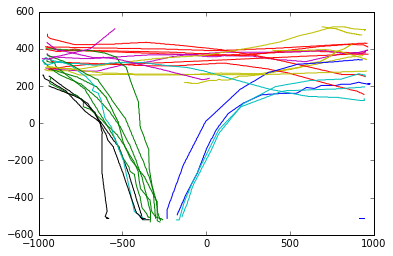

In [99]:
print set(cluster_pred)
color_string = ['b-', 'g-', 'r-','y-','c-','m-','k-','y-'] 
for k in range(n_curves):
    c = color_string[ cluster_pred[k]]
    plt.plot( x_data[k], y_data[k], c )
    

## Clustering basid only on origin and destination
Okay.  So clustering on the whole curve was a massive fail.  Let's try clustering on just the beginning and end-point

In [134]:
n_curves = len(x_data)
X_2B_clstrd = np.zeros( (n_curves, 4) )
for k in range( n_curves ):
    X_2B_clstrd[k,0] = x_data[k][0]
    X_2B_clstrd[k,1] = y_data[k][0]
    X_2B_clstrd[k,2] = x_data[k][-1]
    X_2B_clstrd[k,3] = y_data[k][-1]
    
for col in range( 4 ):
    X_2B_clstrd[:,col] /=  X_2B_clstrd[:,col].std()
    
def distance_metric(a,b):
    #A distance metric on R^4 modulo the involution
    #(x0,x2,x3,x4) -> (x3,x4,x1,x2)
    d = lambda a,b : np.sqrt( np.sum( (a-b)**2 ) )
    T = lambda x: np.array([x[2],x[3],x[0],x[1]])
    return min( d(a,b) , d(T(a),b) )

In [135]:
clusterer = AffinityPropagation(affinity='precomputed', convergence_iter=100)

aff = np.zeros((n_curves, n_curves))
for i in range(n_curves):
    for j in range(i+1,n_curves):
        aff[i,j] = np.exp(-distance_metric( X_2B_clstrd[i], X_2B_clstrd[j])**2)
        aff[j,i] = aff[i,j]

#clusterer.Affinity = aff
cluster_pred = clusterer.fit_predict(aff)

set([0, 1, 2, 3, 4])


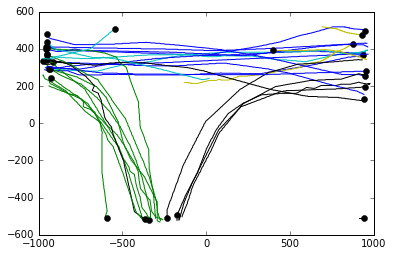

In [136]:
print set(cluster_pred)
color_string = ['b-', 'g-', 'k-','y-','c-','m-','k-','y-'] 
for k in range(n_curves):
    c = color_string[ cluster_pred[k]]
    plt.plot( x_data[k], y_data[k], c )
    plt.plot( x_data[k][0], y_data[k][0], 'ko')